In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.utils import save_image

In [2]:
from models import *

In [3]:
torch.manual_seed(0)

In [4]:
device = 'cuda'
num_channels, latent_dim = 3, 100

In [5]:
dataset = CIFAR10(root='.', download=True, transform=Compose([Resize(32), ToTensor(), Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

Files already downloaded and verified


In [6]:
G = Generator(nc=num_channels, ld=latent_dim).to(device)
D = Discriminator(nc=num_channels, ld=latent_dim, bidirectional=False).to(device)
E = Encoder(nc=num_channels, ld=latent_dim).to(device)

In [7]:
adver_criterion = nn.BCELoss().to(device)
recon_criterion = nn.L1Loss(reduction='sum').to(device)

In [8]:
D_optimizer = optim.Adam(D.parameters(), lr=0.0002)
G_optimizer = optim.Adam(G.parameters(), lr=0.0002)
E_optimizer = optim.Adam(E.parameters(), lr=0.0002)

In [9]:
fixed_latent = (2*torch.rand(64,100,1,1)-1).to(device)
outdir = 'cifar10_dcgan'
os.makedirs(outdir, exist_ok=True)

In [10]:
losses = {
    'D':[],
    'G':[],
    'E':[],
    'I':[]
}

In [11]:
for epoch in range(25):
    for idx, (x, _) in enumerate(dataloader):
        batch_size = x.shape[0]
        x_real = x.detach().to(device)
        
        # Train D
        D.zero_grad()
        
        z_real = E(x_real).detach()
        z_fake = 2*torch.rand(batch_size, latent_dim, 1, 1).to(device)-1
        x_fake = G(z_fake).detach()
        
        real_pred = D(x_real)
        fake_pred = D(x_fake)
        
        d_real_target = torch.ones(batch_size, 1).to(device)
        d_fake_target = torch.zeros(batch_size, 1).to(device)
        
        D_loss = adver_criterion(fake_pred, d_fake_target) + adver_criterion(real_pred, d_real_target)
        D_loss.backward()
        D_optimizer.step()
        
        # Train G
        G.zero_grad()
        
        z_fake = 2*torch.rand(batch_size, latent_dim, 1, 1).to(device)-1
        x_fake = G(z_fake)
        fake_pred = D(x_fake)
        g_target = d_real_target.clone()
        
        G_loss = adver_criterion(fake_pred, g_target)
        G_loss.backward()
        G_optimizer.step()
        
        # Train E
        E.zero_grad()
        
        z_real = E(x_real)
        real_pred = D(x_real)
        
        e_target = torch.ones(batch_size, 1).to(device)
        E_loss = adver_criterion(real_pred, e_target)
        
        E_loss.backward()
        E_optimizer.step()
        
        
        # latent identity Loss
        E.zero_grad()
        G.zero_grad()
        
        z_recon0 = E(x_real)
        x_recon1 = G(z_recon0)
        z_recon1 = E(x_recon1)
        
        I_loss = recon_criterion(x_recon1, x_real)
        #I_loss.backward(retain_graph=True)
        #E_optimizer.step()
        #G_optimizer.step()
        
        losses['D'].append(D_loss.item())
        losses['G'].append(G_loss.item())
        losses['E'].append(E_loss.item())
        losses['I'].append(I_loss.item())
        
    save_image(G(fixed_latent), f'{outdir}/fixed_{epoch+1}.png')
    torch.save(G, f'{outdir}/G_{epoch+1}.pth')
    torch.save(D, f'{outdir}/D_{epoch+1}.pth')
    torch.save(E, f'{outdir}/E_{epoch+1}.pth')
    with open(f'{outdir}/losses.dat', 'wb') as fp:
        pickle.dump(losses, fp)

/home/sharathramku/.local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/sharathramku/.local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/sharathramku/.local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvTranspose2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/sharathramku/.local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "

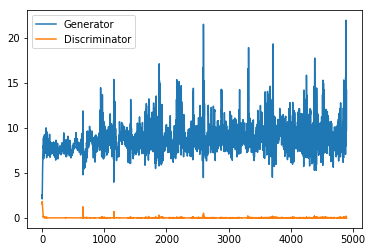

In [12]:
plt.plot(losses['G'], label='Generator')
plt.plot(losses['D'], label='Discriminator')
plt.legend()
plt.show()

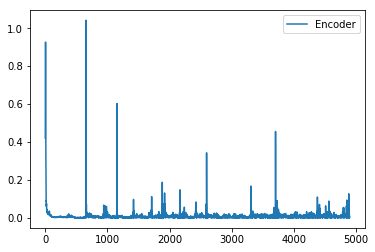

In [13]:
plt.plot(losses['E'], label='Encoder')
plt.legend()
plt.show()

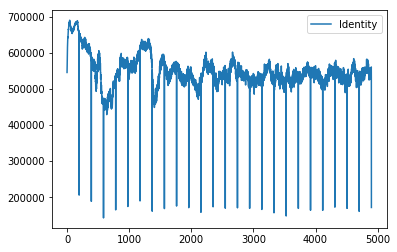

In [14]:
plt.plot(losses['I'], label='Identity')
plt.legend()
plt.show()

In [15]:
numTests = 5
_ = G.eval(), E.eval()

In [16]:
test_dataset = CIFAR10(root='.', download=True, train=False, transform=Compose([Resize(32), ToTensor(), Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

Files already downloaded and verified


In [17]:
ad_losses, post_losses = [], []
for test in range(numTests):
    torch.manual_seed(100+test)
    E_post = Encoder().to(device)
    ft_optimizer = optim.Adam(E_post.parameters(), lr=0.0002)
    for it in range(5000):
        E_post.zero_grad()
        z_recon0 = 2*torch.rand(256, latent_dim, 1, 1).to(device)-1
        x_recon0 = G(z_recon0)
        z_recon1 = E_post(x_recon0)
        x_recon1 = G(z_recon1)
        ft_loss = recon_criterion(x_recon1, x_recon0) + recon_criterion(z_recon1, z_recon0)
        ft_loss.backward(retain_graph=True)
        ft_optimizer.step()
        
    E_post.eval()
    torch.save(E_post, f'{outdir}/Epost_{test+1}.pth')

    ad_loss, post_loss = 0, 0
    for idx, (x, _) in enumerate(test_dataloader):
        batch_size = x.shape[0]
        x_real = x.detach().to(device)
        ad_loss += recon_criterion(G(E(x_real)), x_real).item()
        post_loss += recon_criterion(G(E_post(x_real)), x_real).item()
    ad_loss, post_loss = ad_loss/len(test_dataset), post_loss/len(test_dataset)
    ad_losses.append(ad_loss)
    post_losses.append(post_loss)

In [18]:
print((np.mean(ad_losses), np.std(ad_losses)), (np.mean(post_losses), np.std(post_losses)))

(1649.9581961328126, 9.02284567588096e-06) (919.4905374218749, 11.348126940661285)
